# 笔记

In [73]:
torch.rand(10)

tensor([0.9466, 0.4316, 0.7184, 0.8030, 0.1314, 0.3414, 0.9243, 0.0443, 0.3290,
        0.2211])

In [79]:
torch.randn(10)>0

tensor([ True,  True,  True, False, False,  True, False, False, False,  True])

In [77]:
torch.masked_select(10)

TypeError: masked_select(): argument 'input' (position 1) must be Tensor, not int

# Plantoid数据集

In [2]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='dataset/Cora', name='Cora', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('======================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(edge_index=[2, 10556], test_mask=[2708], train_mask=[2708], val_mask=[2708], x=[2708, 1433], y=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


In [5]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())
    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()



In [3]:
import torch
from torch.nn import Linear
import torch.nn.functional as F

class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(MLP, self).__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

model = MLP(hidden_channels=16)
print(model)



MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)


In [4]:
model = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train():
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(data.x)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss

for epoch in range(1, 201):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')



Epoch: 001, Loss: 1.9615
Epoch: 002, Loss: 1.9557
Epoch: 003, Loss: 1.9505
Epoch: 004, Loss: 1.9423
Epoch: 005, Loss: 1.9327
Epoch: 006, Loss: 1.9279
Epoch: 007, Loss: 1.9144
Epoch: 008, Loss: 1.9087
Epoch: 009, Loss: 1.9023
Epoch: 010, Loss: 1.8893
Epoch: 011, Loss: 1.8776
Epoch: 012, Loss: 1.8594
Epoch: 013, Loss: 1.8457
Epoch: 014, Loss: 1.8365
Epoch: 015, Loss: 1.8280
Epoch: 016, Loss: 1.7965
Epoch: 017, Loss: 1.7984
Epoch: 018, Loss: 1.7832
Epoch: 019, Loss: 1.7495
Epoch: 020, Loss: 1.7441
Epoch: 021, Loss: 1.7188
Epoch: 022, Loss: 1.7124
Epoch: 023, Loss: 1.6785
Epoch: 024, Loss: 1.6660
Epoch: 025, Loss: 1.6119
Epoch: 026, Loss: 1.6236
Epoch: 027, Loss: 1.5827
Epoch: 028, Loss: 1.5784
Epoch: 029, Loss: 1.5524
Epoch: 030, Loss: 1.5020
Epoch: 031, Loss: 1.5065
Epoch: 032, Loss: 1.4742
Epoch: 033, Loss: 1.4581
Epoch: 034, Loss: 1.4246
Epoch: 035, Loss: 1.4131
Epoch: 036, Loss: 1.4112
Epoch: 037, Loss: 1.3923
Epoch: 038, Loss: 1.3055
Epoch: 039, Loss: 1.2982
Epoch: 040, Loss: 1.2543


In [5]:
def test():
    model.eval()
    out = model(data.x)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    return test_acc

test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.5900


# GCN

In [6]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


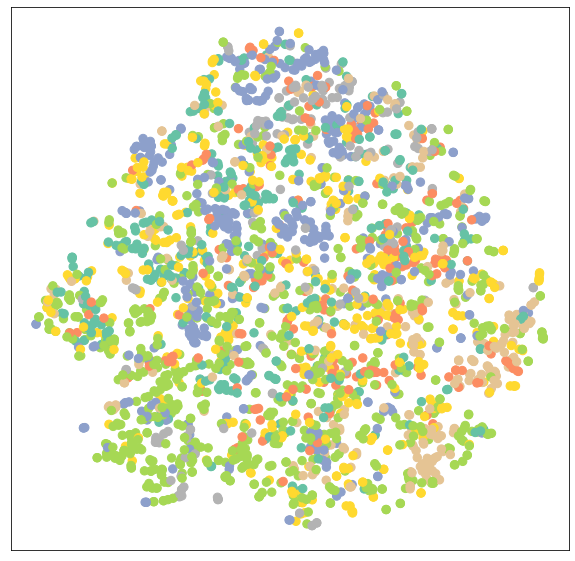

In [8]:
model = GCN(hidden_channels=16)
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

In [9]:
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

for epoch in range(1, 201):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')



Epoch: 001, Loss: 1.9451
Epoch: 002, Loss: 1.9384
Epoch: 003, Loss: 1.9307
Epoch: 004, Loss: 1.9227
Epoch: 005, Loss: 1.9126
Epoch: 006, Loss: 1.9076
Epoch: 007, Loss: 1.8917
Epoch: 008, Loss: 1.8809
Epoch: 009, Loss: 1.8728
Epoch: 010, Loss: 1.8616
Epoch: 011, Loss: 1.8453
Epoch: 012, Loss: 1.8397
Epoch: 013, Loss: 1.8237
Epoch: 014, Loss: 1.8057
Epoch: 015, Loss: 1.7979
Epoch: 016, Loss: 1.7808
Epoch: 017, Loss: 1.7667
Epoch: 018, Loss: 1.7555
Epoch: 019, Loss: 1.7436
Epoch: 020, Loss: 1.7184
Epoch: 021, Loss: 1.7126
Epoch: 022, Loss: 1.6845
Epoch: 023, Loss: 1.6717
Epoch: 024, Loss: 1.6673
Epoch: 025, Loss: 1.6353
Epoch: 026, Loss: 1.6181
Epoch: 027, Loss: 1.5962
Epoch: 028, Loss: 1.5723
Epoch: 029, Loss: 1.5708
Epoch: 030, Loss: 1.5370
Epoch: 031, Loss: 1.5162
Epoch: 032, Loss: 1.4948
Epoch: 033, Loss: 1.4713
Epoch: 034, Loss: 1.4589
Epoch: 035, Loss: 1.4479
Epoch: 036, Loss: 1.4377
Epoch: 037, Loss: 1.4271
Epoch: 038, Loss: 1.3644
Epoch: 039, Loss: 1.3658
Epoch: 040, Loss: 1.3363


In [10]:
def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8140


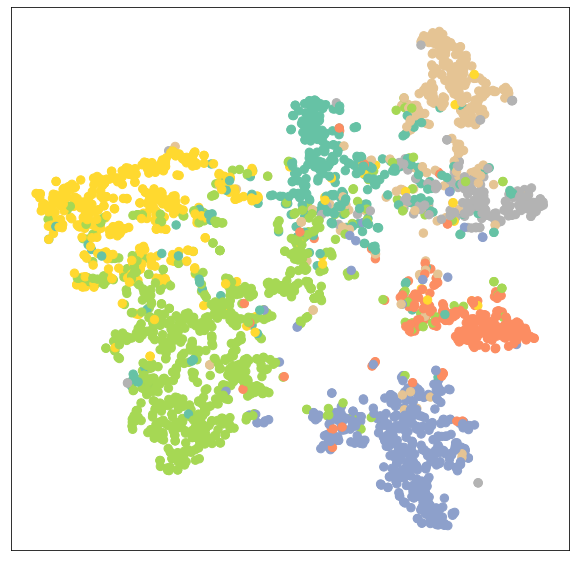

In [11]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

# GAT

In [3]:
import torch
from torch.nn import Linear
import torch.nn.functional as F

from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GAT, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GATConv(dataset.num_features, hidden_channels)
        self.conv2 = GATConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x
    

model = GAT(hidden_channels=16)
print(model) 


GAT(
  (conv1): GATConv(1433, 16, heads=1)
  (conv2): GATConv(16, 7, heads=1)
)


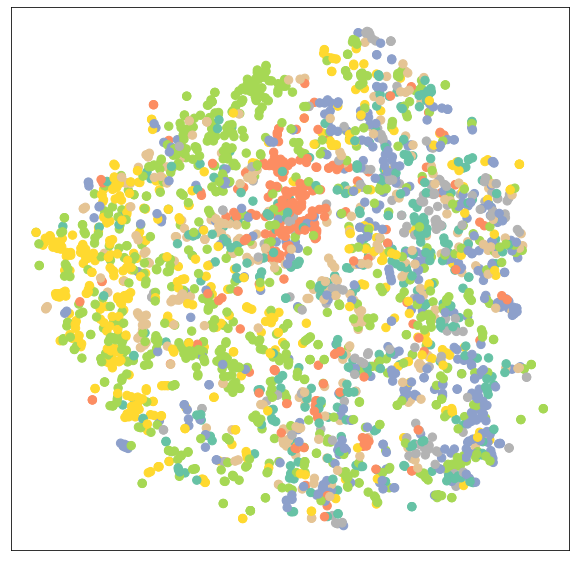

In [6]:
model = GAT(hidden_channels=16)
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

In [7]:
model = GAT(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

for epoch in range(1, 201):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')




Epoch: 001, Loss: 1.9457
Epoch: 002, Loss: 1.9400
Epoch: 003, Loss: 1.9350
Epoch: 004, Loss: 1.9267
Epoch: 005, Loss: 1.9173
Epoch: 006, Loss: 1.9071
Epoch: 007, Loss: 1.8998
Epoch: 008, Loss: 1.8866
Epoch: 009, Loss: 1.8834
Epoch: 010, Loss: 1.8757
Epoch: 011, Loss: 1.8582
Epoch: 012, Loss: 1.8390
Epoch: 013, Loss: 1.8236
Epoch: 014, Loss: 1.8156
Epoch: 015, Loss: 1.7998
Epoch: 016, Loss: 1.7755
Epoch: 017, Loss: 1.7663
Epoch: 018, Loss: 1.7605
Epoch: 019, Loss: 1.7339
Epoch: 020, Loss: 1.7236
Epoch: 021, Loss: 1.6978
Epoch: 022, Loss: 1.6742
Epoch: 023, Loss: 1.6680
Epoch: 024, Loss: 1.6385
Epoch: 025, Loss: 1.6317
Epoch: 026, Loss: 1.5900
Epoch: 027, Loss: 1.5861
Epoch: 028, Loss: 1.5439
Epoch: 029, Loss: 1.5036
Epoch: 030, Loss: 1.4927
Epoch: 031, Loss: 1.4704
Epoch: 032, Loss: 1.4379
Epoch: 033, Loss: 1.4213
Epoch: 034, Loss: 1.4368
Epoch: 035, Loss: 1.3622
Epoch: 036, Loss: 1.3475
Epoch: 037, Loss: 1.3178
Epoch: 038, Loss: 1.3106
Epoch: 039, Loss: 1.2724
Epoch: 040, Loss: 1.2501


In [8]:
def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.7380


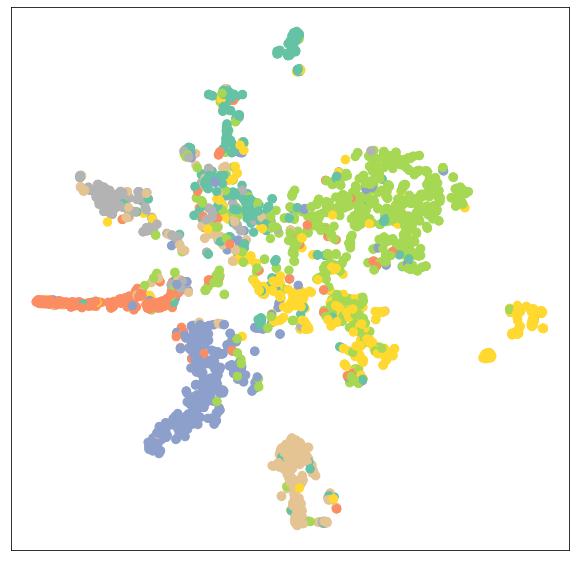

In [9]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

# SAGE

In [62]:
import torch
from torch.nn import Linear
import torch.nn.functional as F

from torch_geometric.nn import SAGEConv

class SAGE(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(SAGE, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = SAGEConv(dataset.num_features, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x
    

model = SAGE(hidden_channels=16)
print(model) 



SAGE(
  (conv1): SAGEConv(8415, 16)
  (conv2): SAGEConv(16, 5)
)


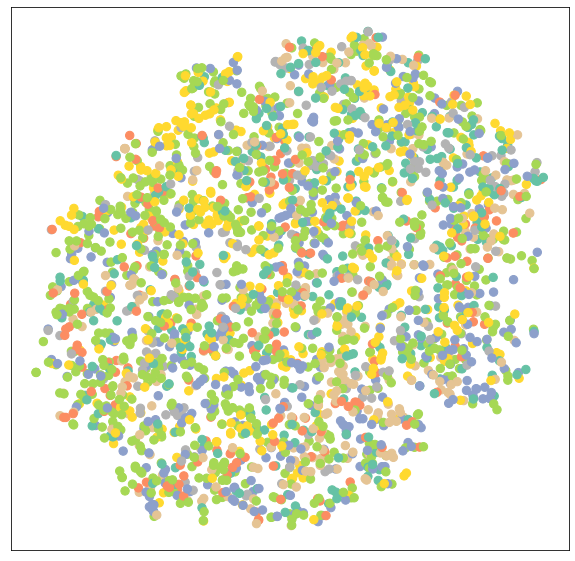

In [15]:
model = SAGE(hidden_channels=16)
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

In [17]:
model = SAGE(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

for epoch in range(1, 201):
    loss = train()
    if epoch > 195:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')





Epoch: 196, Loss: 0.1518
Epoch: 197, Loss: 0.1351
Epoch: 198, Loss: 0.1606
Epoch: 199, Loss: 0.1352
Epoch: 200, Loss: 0.1286


In [18]:
def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.7970


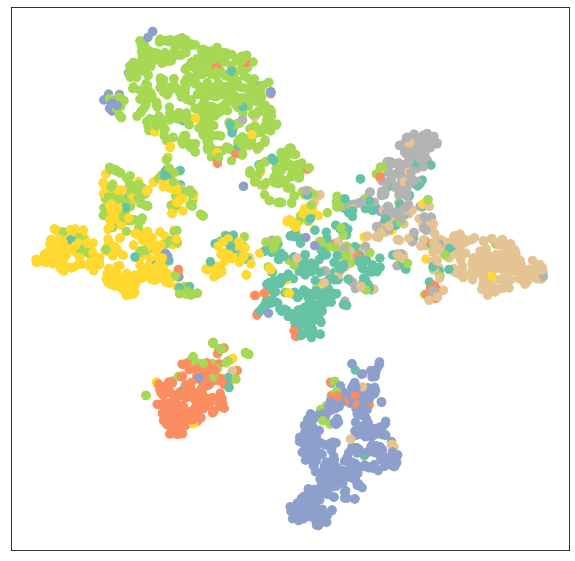

In [19]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

# GraphConv 

In [50]:
import torch
from torch.nn import Linear
import torch.nn.functional as F

from torch_geometric.nn import GraphConv

class GraphC(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GraphC, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GraphConv(dataset.num_features, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x
    



model = GraphC(hidden_channels=16)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

for epoch in range(1, 201):
    loss = train()
    if ( epoch > 195 ) or (epoch %20==0):
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')



Epoch: 020, Loss: 0.5732
Epoch: 040, Loss: 0.1972
Epoch: 060, Loss: 0.1149
Epoch: 080, Loss: 0.0788
Epoch: 100, Loss: 0.0917
Epoch: 120, Loss: 0.0795
Epoch: 140, Loss: 0.0787
Epoch: 160, Loss: 0.0700
Epoch: 180, Loss: 0.0491
Epoch: 196, Loss: 0.0552
Epoch: 197, Loss: 0.0485
Epoch: 198, Loss: 0.0640
Epoch: 199, Loss: 0.0484
Epoch: 200, Loss: 0.0549


In [29]:
def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.7740


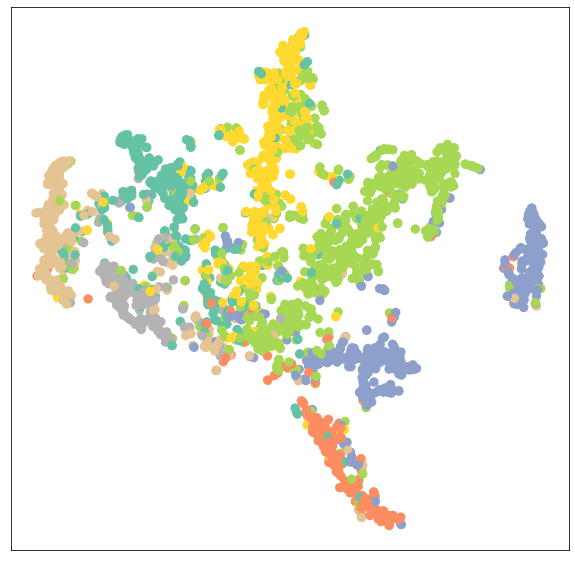

In [30]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

# GatedGraphConv

In [48]:

import torch
from torch.nn import Linear
import torch.nn.functional as F

from torch_geometric.nn import GatedGraphConv



class GatedGraph(torch.nn.Module):
    def __init__(self, hidden_channels,k):
        super(GatedGraph, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GraphConv(dataset.num_features, hidden_channels,aggr='add')
        self.conv2 = GatedGraphConv(hidden_channels, dataset.num_classes ,aggr='add'  )

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x
    



model = GatedGraph(hidden_channels=16,k=1)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

for epoch in range(1, 201):
    loss = train()
    if ( epoch > 195 ) or (epoch %20==0):
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')




Epoch: 020, Loss: 2.1221
Epoch: 040, Loss: 2.1046
Epoch: 060, Loss: 2.1007
Epoch: 080, Loss: 2.0956
Epoch: 100, Loss: 2.0868
Epoch: 120, Loss: 1.9883
Epoch: 140, Loss: 1.8690
Epoch: 160, Loss: 1.7997
Epoch: 180, Loss: 1.7085
Epoch: 196, Loss: 1.7005
Epoch: 197, Loss: 1.7093
Epoch: 198, Loss: 1.7182
Epoch: 199, Loss: 1.6989
Epoch: 200, Loss: 1.7255


In [49]:
def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.3250


# ChebConv

In [52]:



import torch
from torch.nn import Linear
import torch.nn.functional as F

from torch_geometric.nn import ChebConv



class ChebC(torch.nn.Module):
    def __init__(self, hidden_channels,k):
        super(ChebC, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = ChebConv(dataset.num_features, hidden_channels,10,aggr='add')
        self.conv2 = ChebConv(hidden_channels, dataset.num_classes ,10,aggr='add'  )

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x
    



model = ChebC(hidden_channels=16,k=1)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

for epoch in range(1, 201):
    loss = train()
    if ( epoch > 195 ) or (epoch %20==0):
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')


Epoch: 020, Loss: 0.1026
Epoch: 040, Loss: 0.0664
Epoch: 060, Loss: 0.0542
Epoch: 080, Loss: 0.0614
Epoch: 100, Loss: 0.0472
Epoch: 120, Loss: 0.0348
Epoch: 140, Loss: 0.0470
Epoch: 160, Loss: 0.0351
Epoch: 180, Loss: 0.0391
Epoch: 196, Loss: 0.0417
Epoch: 197, Loss: 0.0560
Epoch: 198, Loss: 0.0316
Epoch: 199, Loss: 0.0388
Epoch: 200, Loss: 0.0377


In [53]:
def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.7270


# Coauthor data set

In [80]:
from torch_geometric.datasets import Coauthor
from torch_geometric.transforms import NormalizeFeatures

dataset = Coauthor(root='dataset/Physics', name='Physics', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.
data.train_mask= torch.randn(data.num_nodes)>0
print()
print(data)
print('======================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: CoauthorPhysics():
Number of graphs: 1
Number of features: 8415
Number of classes: 5

Data(edge_index=[2, 495924], train_mask=[34493], x=[34493, 8415], y=[34493])
Number of nodes: 34493
Number of edges: 495924
Average node degree: 14.38
Number of training nodes: 17233
Training node label rate: 0.50
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


In [83]:



import torch
from torch.nn import Linear
import torch.nn.functional as F

from torch_geometric.nn import GATConv



class GAT(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GAT, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GATConv(dataset.num_features, hidden_channels)
        self.conv2 = GATConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x
    



model = GAT(hidden_channels=16)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

for epoch in range(1, 201):
    loss = train()
    if ( epoch > 195 ) or (epoch %20==0):
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')



Epoch: 020, Loss: 1.1721
Epoch: 040, Loss: 0.8646
Epoch: 060, Loss: 0.7094
Epoch: 080, Loss: 0.5941
Epoch: 100, Loss: 0.4671
Epoch: 120, Loss: 0.3841
Epoch: 140, Loss: 0.3386
Epoch: 160, Loss: 0.3076
Epoch: 180, Loss: 0.2889
Epoch: 196, Loss: 0.2722
Epoch: 197, Loss: 0.2704
Epoch: 198, Loss: 0.2736
Epoch: 199, Loss: 0.2761
Epoch: 200, Loss: 0.2699


In [90]:
data.test_mask = (data.train_mask == False)

In [91]:
def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.9417
